# Benchmark: Centroid computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the centroid of the multi-polygon representing all districts of India a 100,000 times.

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_centroid -- --out-file ../analysis/benchmark_centroid/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_centroid/data.json
### Statistics: Raw data
        duration.total_ms             
program               geo         geos
count          200.000000   200.000000
mean           222.993668  2605.139837
std              8.643582    23.692176
min            217.884133  2579.163078
25%            219.332077  2592.362571
50%            220.257035  2599.614591
75%            221.919736  2607.730647
max            290.826407  2752.117866


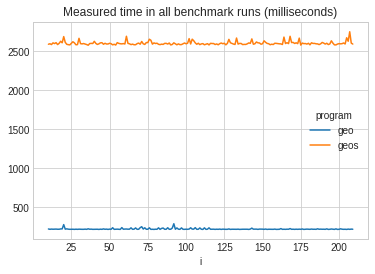

### Statistics: After outlier removal
        duration.total_ms             
program               geo         geos
count          181.000000   181.000000
mean           221.780201  2599.462751
std              5.016634    11.246033
min            217.910908  2579.163078
25%            219.312999  2591.592731
50%            220.178933  2598.755030
75%            221.480761  2604.360874
max            239.571223  2642.432499


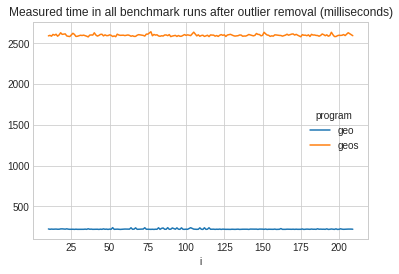

## Absolute difference in runtimes compared to geo
        difference_ms
program          geos
count      181.000000
mean      2377.682550
std         13.452098
min       2344.269981
25%       2369.729547
50%       2378.695880
75%       2384.502067
max       2423.691156


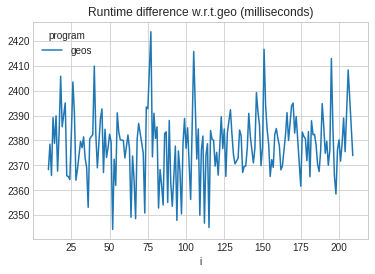

## Relative difference (percent) in runtimes compared to geo
        relative_difference_percent
program                        geos
count                    181.000000
mean                    1072.681973
std                       26.775816
min                      978.527367
25%                     1073.704437
50%                     1080.550824
75%                     1085.015536
max                     1108.016949


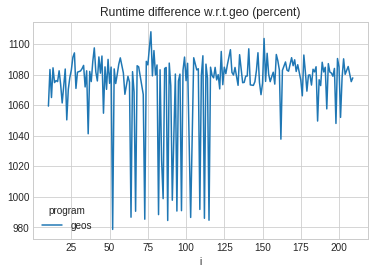

In [1]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb